In [22]:
import numpy as np
from scipy.stats import percentileofscore
import pandas as pd

# 原始 dataset 數值

data = pd.read_csv('/home/ianlee/opt_ian/Model_Create_and_Results1/Pvk_additives/0_Create_Ground_Truth_Model/datasets/combined_compiledData.csv')

original_values = data['crystal_size'].values

#print(original_values)

std_o = (original_values).std()  # 計算標準差
mean_o = (original_values).mean()

print(std_o, mean_o)

#print(original_values)

# 假設有 3 個 dataset 的最佳解數值

methods = ['ABC','PSO','Random']
rounds = ['round1', 'round2', 'round3', 'round4', 'round5', 'round6','round7','round8','round9','round10']

bestnn = {}

for method in methods:
    best = {}
    for roundn in rounds:
        # 讀取 CSV
        df = pd.read_csv(f'/home/ianlee/opt_ian/Model_Create_and_Results1/Pvk_additives/3_Make_New_Data_Predictor/{method}/{roundn}/cycle5.csv')  # 替換成你的檔案路徑

        # 檢查欄位
        if 'crystal_size' not in df.columns:
            raise ValueError("欄位 'crystal_size' 不存在於 CSV 中")

        # 分組
        group_size = 10
        groups = [df['crystal_size'][i:i+group_size].values for i in range(0, len(df), group_size)]
        group_max = [max(g) for g in groups]
        cumulative_max = [max(group_max[:i+1]) for i in range(len(group_max))]
        best[roundn] = cumulative_max
        
    bestnn[method] = best    
    # 將所有 list 轉成 numpy array
    all_lists = np.array(list(best.values()))  # shape: (5, n)

dict1 = bestnn['ABC']
dict2 = bestnn['PSO']
dict3 = bestnn['Random']

best_solutions = {}
best_solutions['ABC'] = np.array([v[-1] for v in dict1.values()])
best_solutions['PSO'] =  np.array([v[-1] for v in dict2.values()])
best_solutions['Random'] = np.array([v[-1] for v in dict3.values()])

# 計算每個最佳解的 percentile rank
for method in methods:
    pr_list = [percentileofscore(original_values, val, kind='rank') for val in best_solutions[method]]
    
    # 計算平均 PR
    avg_pr = np.mean(pr_list)

    Z = (np.mean(best_solutions[method])-mean_o)/std_o  # 計算平均最佳解

    Improvement = (np.mean(best_solutions[method]) - 1.66)/std_o
    print("method:%s\n10 rounds best solutions PR:\n"%(method), pr_list)
    print("mean PR:", avg_pr)
    print("mean Z-score:", Z)
    #print("mean improvement (how many std):", Improvement)
    print("--------------------------------------------------")


0.5967368372249232 0.6782390625
method:ABC
10 rounds best solutions PR:
 [99.65277777777777, 97.74305555555556, 97.74305555555556, 97.74305555555556, 97.74305555555556, 97.74305555555556, 97.91666666666667, 96.70138888888889, 97.74305555555556, 97.74305555555556]
mean PR: 97.84722222222221
mean Z-score: 2.3573365861962174
--------------------------------------------------
method:PSO
10 rounds best solutions PR:
 [97.74305555555556, 97.91666666666667, 99.30555555555556, 97.74305555555556, 99.30555555555556, 99.65277777777777, 99.65277777777777, 96.00694444444444, 96.35416666666667, 96.18055555555556]
mean PR: 97.98611111111111
mean Z-score: 2.4077742167677334
--------------------------------------------------
method:Random
10 rounds best solutions PR:
 [99.30555555555556, 98.61111111111111, 99.65277777777777, 97.74305555555556, 99.65277777777777, 98.26388888888889, 98.26388888888889, 97.74305555555556, 98.61111111111111, 99.65277777777777]
mean PR: 98.75
mean Z-score: 2.6346612888109724

In [23]:
import pandas as pd
import numpy as np

methods = ['ABC', 'PSO', 'Random']
rounds = ['round1', 'round2', 'round3', 'round4', 'round5', 'round6', 'round7', 'round8', 'round9', 'round10']

bestnn = {}
best_smiles = {}

for method in methods:
    best = {}
    best_smi = {}
    
    for roundn in rounds:
        # 讀取 CSV
        df = pd.read_csv(
            f'/home/ianlee/opt_ian/Model_Create_and_Results1/Pvk_additives/3_Make_New_Data_Predictor/{method}/{roundn}/cycle5.csv'
        )
        
        if 'crystal_size' not in df.columns or 'SMILES' not in df.columns:
            raise ValueError("CSV 中必須同時包含 'crystal_size' 和 'SMILES' 欄位")

        # 分組
        group_size = 10
        groups = [df.iloc[i:i+group_size] for i in range(0, len(df), group_size)]
        
        # 每組的最佳 crystal_size 與對應 SMILES
        group_best_rows = [g.loc[g['crystal_size'].idxmax()] for g in groups]
        
        # 累積最大值（best so far）
        cumulative_best_rows = []
        current_best = None
        for row in group_best_rows:
            if current_best is None or row['crystal_size'] > current_best['crystal_size']:
                current_best = row
            cumulative_best_rows.append(current_best)
        
        # 存 crystal_size
        best[roundn] = [r['crystal_size'] for r in cumulative_best_rows]
        # 存 SMILES
        best_smi[roundn] = [r['SMILES'] for r in cumulative_best_rows]
    
    bestnn[method] = best
    best_smiles[method] = best_smi

# 範例：印出 ABC 的 round1 前幾 cycle 的最佳 SMILES

top_smiles_each_round = {m: {r: best_smiles[m][r][-1] for r in rounds} for m in methods}

for method in methods:
    print(f"Best SMILES for {method} in each round:")
    for roundn, smiles in top_smiles_each_round[method].items():
        print(f"{smiles}")
#print(top_smiles_each_round)


Best SMILES for ABC in each round:
CC1C[NH2+]CC1c1ccccc1
Cc1c(C2CC[NH2+]CC2)cnc2c1CC=C2
CCOc1c(C)ccnc1C=C1CCOCC1
Cc1ccc2ccccc2n1
Cc1oc2c(C[NH3+])nc(CO)c(C)c2c1C
OC1CCOC2(C[NH2+]CCO2)C1
CCOc1ncnc2nc(-c3ccccc3)[nH]c12
Cc1noc(C2CCC[NH2+]2)c1O
Cc1cc(C)c2cccnc2c1
Cc1cc(-c2cnccn2)nc2ccccc12
Best SMILES for PSO in each round:
ClC1=Nc2[nH]cnc2S12C=CCCC2
Cc1cc2nc(N)n(C)c2nn1
COC=NS(=O)(=O)c1cccnn1
Cc1ccnc(-c2[c-]cccc2)n1
Cc1cnc2c(C)cc(C=NO)cc2c1
Cc1ccc([NH+]2CCCCC2)c(C)c1
Cc1ccc2ccccc2n1
Cc1c(C)c2c(c(S(=O)O)c1O)OCO2
Cc1c2ccccc2nc2c1ccc1cccnc12
Cc1nc2cn[nH]c2c(C2CC[NH2+]C2)c1C
Best SMILES for Random in each round:
CC(NC(N)=[NH2+])C(=O)NCCN
CC(C)S(=N)c1nc2ccsc2s1
Nc1nc2c(N)c[nH]c2nc1O
Cc1cc([NH-])c(OCS)c(Br)c1
Cc1nc(N)c(N2CCOCC2)c(N)n1
COc1cccc(-c2c(C)noc2-c2c[n-]cn2)c1OC
NC12C=CC=CC1=CC13CC4CC(CC(C4)C1(Br)O2)C3=S
C=C(OC(N)=O)C(N)=[NH+]C(C)C(=O)N(C)C
CC(C)C(C(=O)c1ncno1)c1ccc(Cl)cc1
CC(=O)OC(C)(C)N(C(N)=O)C(C)(O)c1ccc2c(c1)CCO2


In [24]:
from scipy.stats import percentileofscore
import numpy as np
import pandas as pd

# 原始 dataset 數值
data = pd.read_csv('/home/ianlee/opt_ian/Model_Create_and_Results1/Pvk_additives/0_Create_Ground_Truth_Model/datasets/data_nocor2r.csv')
original_values = data['crystal_size'].values

methods = ['ABC', 'PSO', 'Random']
rounds = ['round1', 'round2', 'round3', 'round4', 'round5', 'round6', 'round7', 'round8', 'round9', 'round10']

avg_over90 = {}

for method in methods:
    over90_counts = []
    for roundn in rounds:
        # 讀取 CSV
        df = pd.read_csv(f'/home/ianlee/opt_ian/Model_Create_and_Results1/Pvk_additives/3_Make_New_Data_Predictor/{method}/{roundn}/cycle5.csv')

        if 'crystal_size' not in df.columns:
            raise ValueError("欄位 'crystal_size' 不存在於 CSV 中")

        # 計算每個點的 PR
        pr_values = [percentileofscore(original_values, val, kind='rank') for val in df['crystal_size']]

        # 計算這個 round PR > 90 的點數
        count_over90 = sum(pr > 90 for pr in pr_values)
        over90_counts.append(count_over90)

    # 計算該 method 平均有多少個點 PR > 90
    avg_over90[method] = np.mean(over90_counts)

# 輸出結果
for method, avg_count in avg_over90.items():
    print(f"{method} 平均每 round 有 {avg_count:.2f} 個點 PR > 90")


ABC 平均每 round 有 17.70 個點 PR > 90
PSO 平均每 round 有 16.80 個點 PR > 90
Random 平均每 round 有 17.80 個點 PR > 90


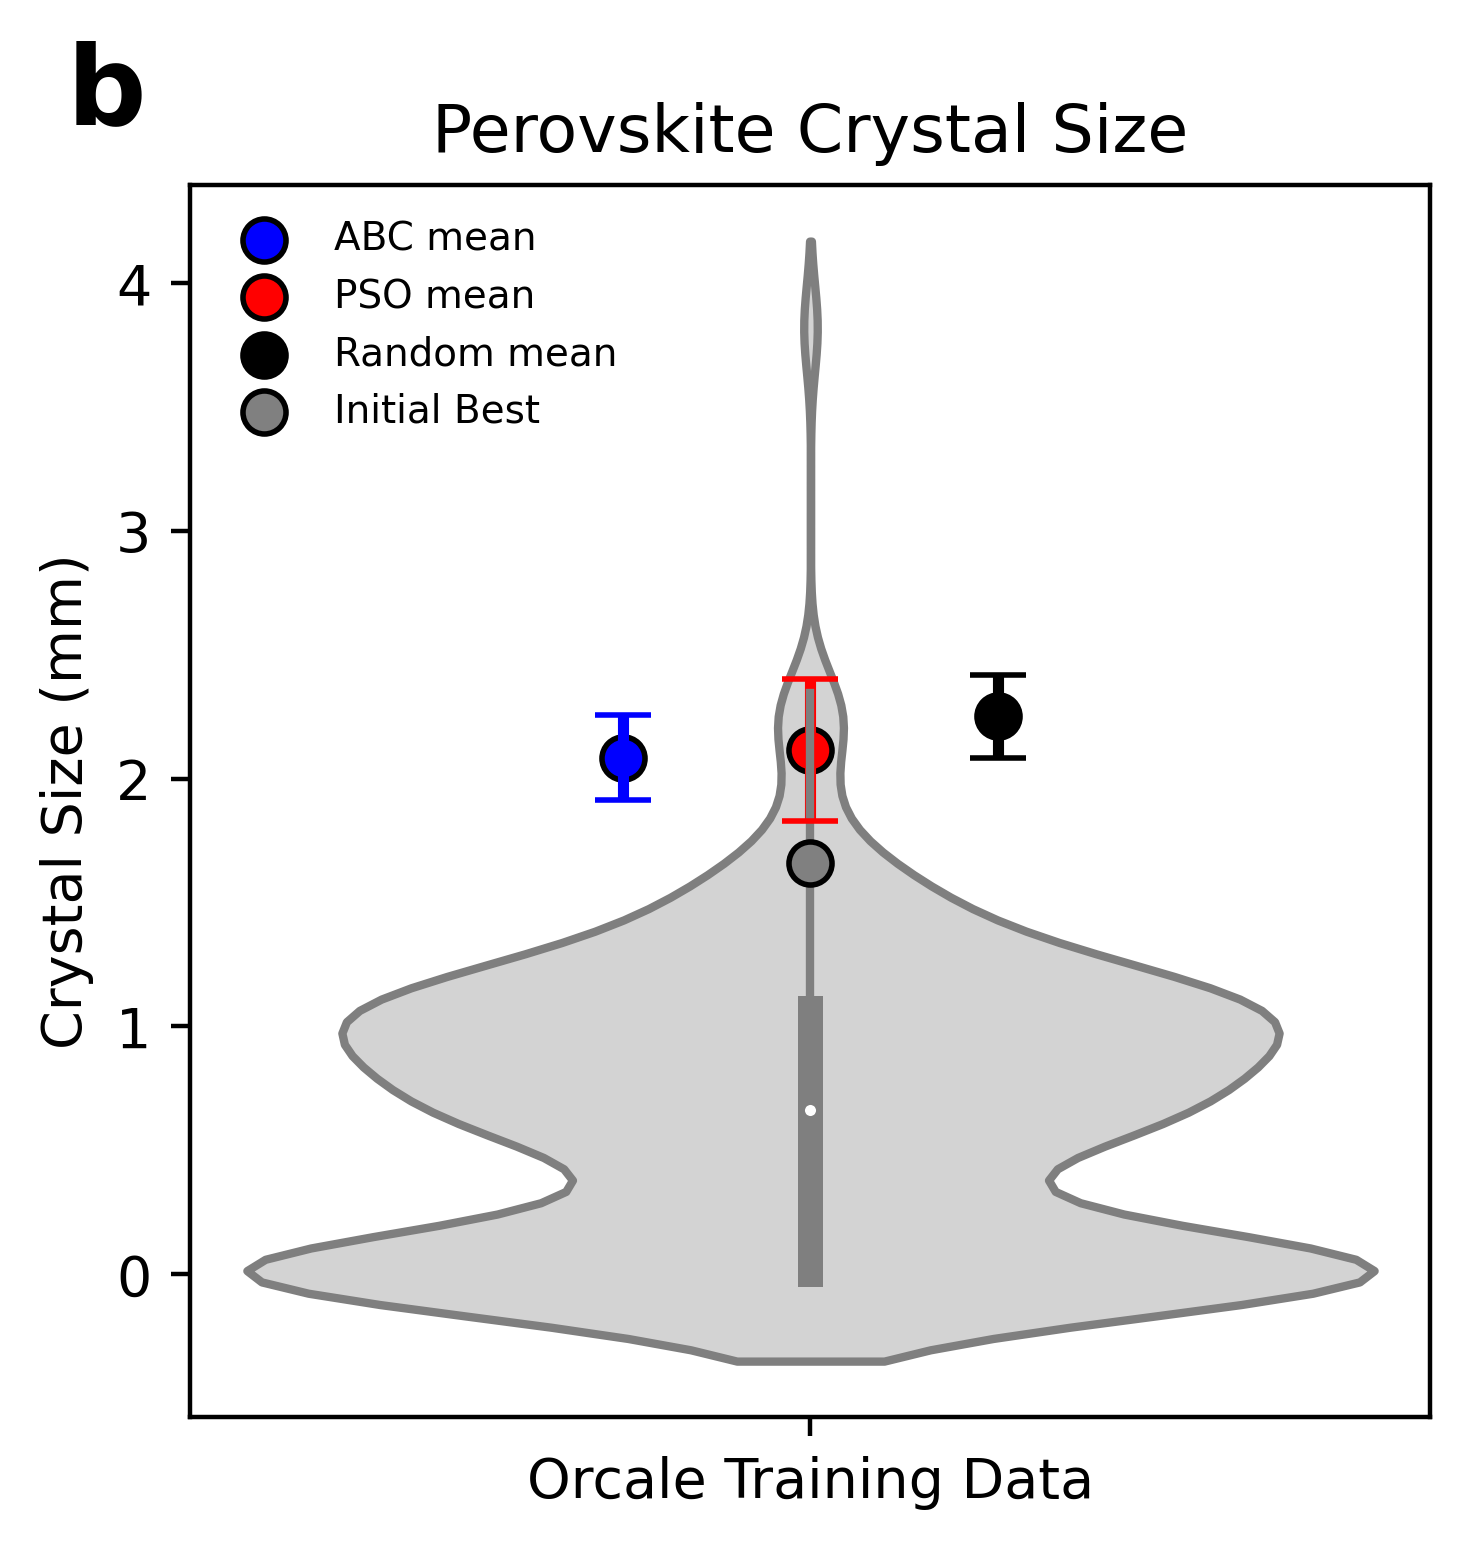

In [32]:
import numpy as np
from scipy.stats import sem  # 計算標準誤差（optional）
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ...前面資料讀取與計算保持不變...

plt.figure(figsize=(4,4), dpi=400)

# 小提琴圖
sns.violinplot(y=original_values, color='lightgray', width=0.3)

# 改成畫平均值與標準差誤差線
colors = {'ABC': 'blue', 'PSO': 'red', 'Random': 'black'}
for i, method in enumerate(methods):
    mean_val = best_solutions[method].mean()
    std_val = best_solutions[method].std()
    # 水平座標稍微偏移，避免重疊
    x = 0 + 0.05 * (i - 1)
    
    # 畫平均值點
    plt.scatter(x, mean_val, color=colors[method], s=60, edgecolor='black', label=f'{method} mean')
    # 畫誤差線 (± std)
    plt.errorbar(x, mean_val, yerr=std_val, fmt='none', ecolor=colors[method], elinewidth=2, capsize=5)

# 標出 initial best = 1.66
initial_best = 1.66
plt.scatter(
    0, initial_best,
    color='grey', s=60, edgecolor='black',
    label='Initial Best', zorder=5
)

plt.ylabel('Crystal Size (mm)')
plt.xticks([0], ['Orcale Training Data'])
plt.text(-0.1, 1.05, 'b', fontsize=20, fontweight='bold',
         transform=plt.gca().transAxes)  # 軸座標系

plt.title('Perovskite Crystal Size')
plt.legend(frameon=False, loc='upper left', fontsize=7)
plt.savefig('/home/ianlee/opt_ian/Model_Create_and_Results1/Pvk_additives/4_Final_Anslysis_Like_EDBO/best_solutions_violin_plot.png', bbox_inches='tight')
plt.show()


In [33]:
#合併圖片
import os
from PIL import Image

path1 = '/home/ianlee/opt_ian/Model_Create_and_Results1/Pvk_additives/4_Final_Anslysis_Like_EDBO/best_solutions_violin_plot.png'
path2 = '/home/ianlee/opt_ian/Model_Create_and_Results1/Direct_ary/4_Final_Anslysis_Like_EDBO/best_solutions_violin_plot.png'
img1 = Image.open(path2)
img2 = Image.open(path1)


# 假設三張圖大小相同，取得寬高
width, height = img1.size

# 建立新圖像，寬度為三倍，垂直高度不變
new_img = Image.new('RGB', (width*2, height))

# 將三張圖貼上去
new_img.paste(img1, (0, 0))
new_img.paste(img2, (width, 0))

# 儲存或顯示
new_img.save('/home/ianlee/opt_ian/Model_Create_and_Results1/Pvk_additives/4_Final_Anslysis_Like_EDBO/comb_best_solutions_violin_plot.png')
new_img.show()


(eog:12698): Gtk-WARNING **: 21:02:54.341: cannot open display: 
